In [85]:
import numpy,pandas
from sklearn.decomposition import PCA

#For the preprocessing we need the data from Dream9.xlsx
Dream9_training=pandas.read_excel('Dream9.xlsx',"trainingData") 
Dream9_scoring=pandas.read_excel('Dream9.xlsx',"scoringData")
Dream9=pandas.concat([Dream9_training,Dream9_scoring])

#Division of types of Variables
All=list(Dream9_training.keys())
Sc=list(Dream9_scoring.keys())

#Dependent variables are present in the training set but not in the scoring set
Dependent=[]
for v in All:
    if v not in Sc:
        Dependent+=[v]

#Categorical variables have discrete values and can't be measured by euclidean distances
Categorical=['SEX', 'PRIOR.MAL', 'PRIOR.CHEMO', 'PRIOR.XRT', 'Infection', 'cyto.cat', 
             'ITD', 'D835', 'Ras.Stat', 'resp.simple', 'Relapse', 'vital.status']

#The last 231 variables are proteins
Protein=All[-231:]



###############
#  Functions  #
###############

def alias(Series,aliases):
    #Changes the values on a Series with aliases as a dict that transform the old values in the new values
    new_Series=(Series=='This creates and new series')
    for key,data in zip(Series.keys(),Series):
        new_Series[key]=False
        for val in aliases:
            try:
                if numpy.isnan(data):
                    new_Series[key]=numpy.nan
            except:
                pass             
            if data==val:
                new_Series[key]=aliases[val]
                break
    return new_Series

def make_pca(Table,All_Data,n,name='PCA'):
    pca = PCA(n_components=n)
    pca.fit(All_Data[Table.keys()])
    trans_PCA=pca.transform(Table)
    return pandas.DataFrame(trans_PCA,columns=['%s_%i'%(name,i+1) for i in range(n)],index=Table.index)

def split(Series,All_Data):
    #For Series with multiple values, creates a table with a column for each unique value
    #The value is True for the correct column and False for all the other columns
    D=[]
    for value in All_Data[Series.name].unique():
        q=(Series==value)
        q.name='%s=%s'%(q.name,value)
        D+=[q]
    return pandas.concat(D,axis=1)


def difference_from_mean(Table,All_Data):
    #This function creates a new Table with the values equal to (value-mean)/std
    #Since most of the values are already centered around 0 it woul be better to just take the square?
    D=[]
    for i,var in enumerate(Table.keys()):
        m=All_Data[var].mean()
        std=All_Data[var].std()
        D+=[(Table[var]-m)**2/std]
        D[i].name='%s_Normalized'%var
    return pandas.concat(D,axis=1)

def squared(Table):
    #This function squares all the values on a table
    D=[]
    for i,var in enumerate(Table.keys()):
        D+=[Table[var]**2]
        D[i].name='%s_Squared'%var
    return pandas.concat(D,axis=1)

def cutoff(Series,cutoff):
    #This function makes values above a threeshold equal to the threeshold
    new_Series=Series.copy()
    for key,data in zip(Series.keys(),Series):
        if data>cutoff:
            new_Series[key]=cutoff
        else:
            new_Series[key]=data
    new_Series.name='%s_cut'%Series.name
    return new_Series
    
####################
#  Pre-processing  #
####################    
    
def PreProcess(table,Dream9):
    #Select all variables that are not caregorical
    Tables=[table[[v for v in table.keys() if v not in Categorical]]]
    
    #Convert yes/no to 1/0
    Alias_Dict={'SEX':{'F':1},'PRIOR.MAL':{'YES':1},'PRIOR.CHEMO':{'YES':1},'PRIOR.XRT':{'YES':1},
                'Infection':{'Yes':1},'ITD':{'POS':1,'ND':numpy.nan},'D835':{'POS':1,'ND':numpy.nan},
                'Ras.Stat':{'POS':1,'NotDone':numpy.nan},'resp.simple':{'CR':1},'Relapse':{'Yes':1},
                'vital.status':{'A':1}}
    Aliased=[]
    for key in Alias_Dict:
        if key in table.keys():
            Aliased+=[alias(table[key],Alias_Dict[key])]
    Tables+=[pandas.concat(Aliased,axis=1)]
    
    #Split data that has multiple values
    Tables+=[split(table['cyto.cat'],Dream9)]
    
    #Create new data for protein
    #Tables+=[difference_from_mean(table[Protein],Dream9)]
    
    #Create new data for protein
    Tables+=[squared(table[Protein])]
    Tables+=[make_pca(table[Protein],Dream9,200)]
    Tables+=[make_pca(squared(table[Protein]),squared(Dream9[Protein]),200,name='PCA_Sq')]
    
    #Join everything
    
    Cut=[]
    for key in ['Overall_Survival','Remission_Duration']:
        if key in table.keys():
            Cut+=[cutoff(table[key],130)]
    if len(Cut)>0:
        Tables+=[pandas.concat(Cut,axis=1)]

    return pandas.concat(Tables,axis=1)

if __name__=='__main__':
   
    #This part is to test the function

    #Open the data and read in pandas
    Dream9_training=pandas.read_excel('Dream9.xlsx',"trainingData")
    Dream9_scoring=pandas.read_excel('Dream9.xlsx',"scoringData")
    Dream9=pandas.concat([Dream9_training,Dream9_scoring])

    #Create the new tables
    Q_training=PreProcess(Dream9_training,Dream9)
    Q_scoring=PreProcess(Dream9_scoring,Dream9)

    #Save the tables as csv
    Q_training.to_csv('Qtraining.csv')
    Q_scoring.to_csv('Qscoring.csv')

    #Number of columns and rows of new Table
    print Q_training.shape
    print Q_scoring.shape

(187, 916)
(70, 909)


In [86]:
#Correlation for Continuous variables
Corr=pandas.DataFrame()
Q_Dependent=Dependent+['Overall_Survival_cut','Remission_Duration_cut']
for Variable in Q_Dependent:
    C=Q_training[[t for t in Q_training.keys() if (t not in Q_Dependent)]+[Variable]].corr()[Variable][:-1]
    Corr=Corr.append(C)
#Most important variables for prediction
Variables_for_prediction={'pCR':'resp.simple','pRelapse':'Relapse','OS':'Overall_Survival_cut','Remission':'Remission_Duration_cut'}
Selected_variables={}
for Pred in Variables_for_prediction:
    Variable=Variables_for_prediction[Pred]
    print Corr.T.sort(Variable)[Variable][Corr.T.sort(Variable)[Variable]**2>0.2**2]
    Selected_variables.update({Pred:Corr.T.sort(Variable)[Variable][Corr.T.sort(Variable)[Variable]**2>0.2**2].index})

NPM1.3542          -0.252036
PCA_Sq_146         -0.248592
CD34               -0.241693
PCA_4              -0.226394
ERG                -0.215514
PCA_46             -0.202714
PCA_74             -0.200759
PCA_54              0.207915
PIK3CA              0.208228
cyto.cat=diploid    0.216598
PCA_Sq_38           0.239467
Name: resp.simple, dtype: float64
PCA_176              -0.269860
PCA_Sq_171           -0.263809
PCA_Sq_65            -0.223651
PCA_Sq_37            -0.218231
PCA_Sq_66            -0.217023
HGB                  -0.215277
D835                 -0.214264
SMAD5                -0.202269
PCA_Sq_103           -0.200499
EGFR.pY992_Squared    0.216344
PCA_Sq_105            0.217952
GAPDH_Squared         0.223614
TP53                  0.232152
PCA_95                0.232254
PCA_21                0.238647
ITD                   0.243735
PCA_54                0.249687
CD13                  0.265287
Name: Relapse, dtype: float64
HSP90AA1_B1        -0.278365
Age.at.Dx          -0.277940
H

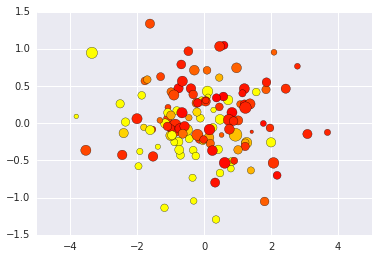

In [97]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = Q_training['PCA_21']
y = Q_training['PCA_Sq_151']
colors = Q_training['Remission_Duration_cut']
area = Q_training['PCA_28']*25+75 # 0 to 15 point radiuses

plt.scatter(x, y, s=area, c=colors,cmap=matplotlib.cm.autumn)
plt.show()

In [104]:
#Calculate how much information in gained on each column
#Calculate the entropy of the subset
def information_gain(Table,Dependent,Independent):
    freq=[]
    for dval in Table[Dependent].unique():
        freq+=[sum(Table[Dependent]==dval)]
    Freq=[float(f)/sum(freq) for f in freq]
    E=0
    for f in Freq:
        E+=-f*np.log(f)/np.log(2)
    print 'Subset Entropy:', E
    Vars=[]

    #Calculate the entropy of each variable
    for ind in Independent:     
        if ind in Categorical:
            IG=E
            for ival in Table[ind].unique():
                SubTable=Table[Table[ind]==ival]
                #print SubTable
                freq=[]
                for dval in Table[Dependent].unique():
                    freq+=[sum(SubTable[Dependent]==dval)]
                Freq=[float(f)/sum(freq) for f in freq]
                #print Freq
                ES=0
                for f in Freq:
                    ES+=-f*np.log(f)/np.log(2) if f<>0 else 0
                #print ES
                IG-=float(len(SubTable))/len(Table)*ES
            print 'Information gain from %s: %f'%(ind,IG)
            Vars+=[(IG,ind)]
        else:
            Threeshold=[]
            for ival in np.arange(min(Table[ind]),max(Table[ind]),(max(Table[ind])-min(Table[ind]))/100.0):
                IG=E
                SubTableA=Table[Table[ind]<ival]
                SubTableB=Table[Table[ind]>=ival]
                if len(SubTableA)<1 or len(SubTableB)<1:
                    continue
                freq=[]
                for dval in Table[Dependent].unique():
                    freq+=[sum(SubTableA[Dependent]==dval)]
                Freq=[float(f)/sum(freq) for f in freq]
                #print Freq
                ES=0
                for f in Freq:
                    ES+=-f*np.log(f)/np.log(2) if f<>0 else 0
                #print ES
                IG-=float(len(SubTableA))/len(Table)*ES
                #print SubTable
                freq=[]
                for dval in Table[Dependent].unique():
                    freq+=[sum(SubTableB[Dependent]==dval)]
                Freq=[float(f)/sum(freq) for f in freq]
                #print Freq
                ES=0
                for f in Freq:
                    ES+=-f*np.log(f)/np.log(2) if f<>0 else 0
                #print ES
                IG-=float(len(SubTableB))/len(Table)*ES
                Threeshold+=[(IG,ival)]
            Threeshold.sort(reverse=True)
            #print Threeshold
            #break
            print 'Information gain from %s: %f at theeshold:%f'%(ind,Threeshold[0][0],Threeshold[0][1])
            if len(Threeshold)>0:
                Vars+=[(Threeshold[0][0],ind,Threeshold[0][1])]
            else:
                Vars+=[(0,ind)]
            
Independent=[v for v in Q_training.keys() if v in Q_scoring.keys()]
information_gain(Q_training,'resp.simple',Independent)

Subset Entropy: 0.880636230815
Information gain from Age.at.Dx: 0.035774 at theeshold:79.011100
Information gain from AHD: 0.042226 at theeshold:4.320000
Information gain from WBC: 0.007728 at theeshold:7.656000
Information gain from ABS.BLST: 0.009359 at theeshold:35808.000000
Information gain from BM.BLAST: 0.018860 at theeshold:77.600000
Information gain from BM.MONOCYTES: 0.025456 at theeshold:18.720000
Information gain from BM.PROM: 0.015594 at theeshold:4.930000
Information gain from PB.BLAST: 0.016287 at theeshold:11.760000
Information gain from PB.MONO: 0.034290 at theeshold:43.990000
Information gain from PB.PROM: 0.025456 at theeshold:2.940000
Information gain from HGB: 0.040996 at theeshold:10.153000
Information gain from PLT: 0.020002 at theeshold:37.410000
Information gain from LDH: 0.049883 at theeshold:320.680000
Information gain from ALBUMIN: 0.038991 at theeshold:4.183000
Information gain from BILIRUBIN: 0.020311 at theeshold:0.161000
Information gain from CREATININE: 

KeyboardInterrupt: 